In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/myPOLITA

/gdrive/My Drive/myPOLITA


In [3]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import numpy as np
import keras
import os as os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from tensorflow.keras import activations
from keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, Average, BatchNormalization, Dense, Flatten
from sklearn.preprocessing import minmax_scale
from tensorflow.keras import regularizers
from numpy.random import default_rng

rng = default_rng()
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [4]:
# Random seed for reproducibility
seed = 1337

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Dataset inspection

In [5]:
labels = {0:'Apple', 
          1:'Blueberry', 
          2:'Cherry', 
          3:'Corn', 
          4:'Grape', 
          5:'Orange', 
          6:'Peach', 
          7:'Pepper', 
          8:'Potato', 
          9:'Raspberry', 
          10:'Soybean', 
          11:'Squash', 
          12:'Strawberry', 
          13:'Tomato'}

In [6]:
dataset_dir = 'dataset'

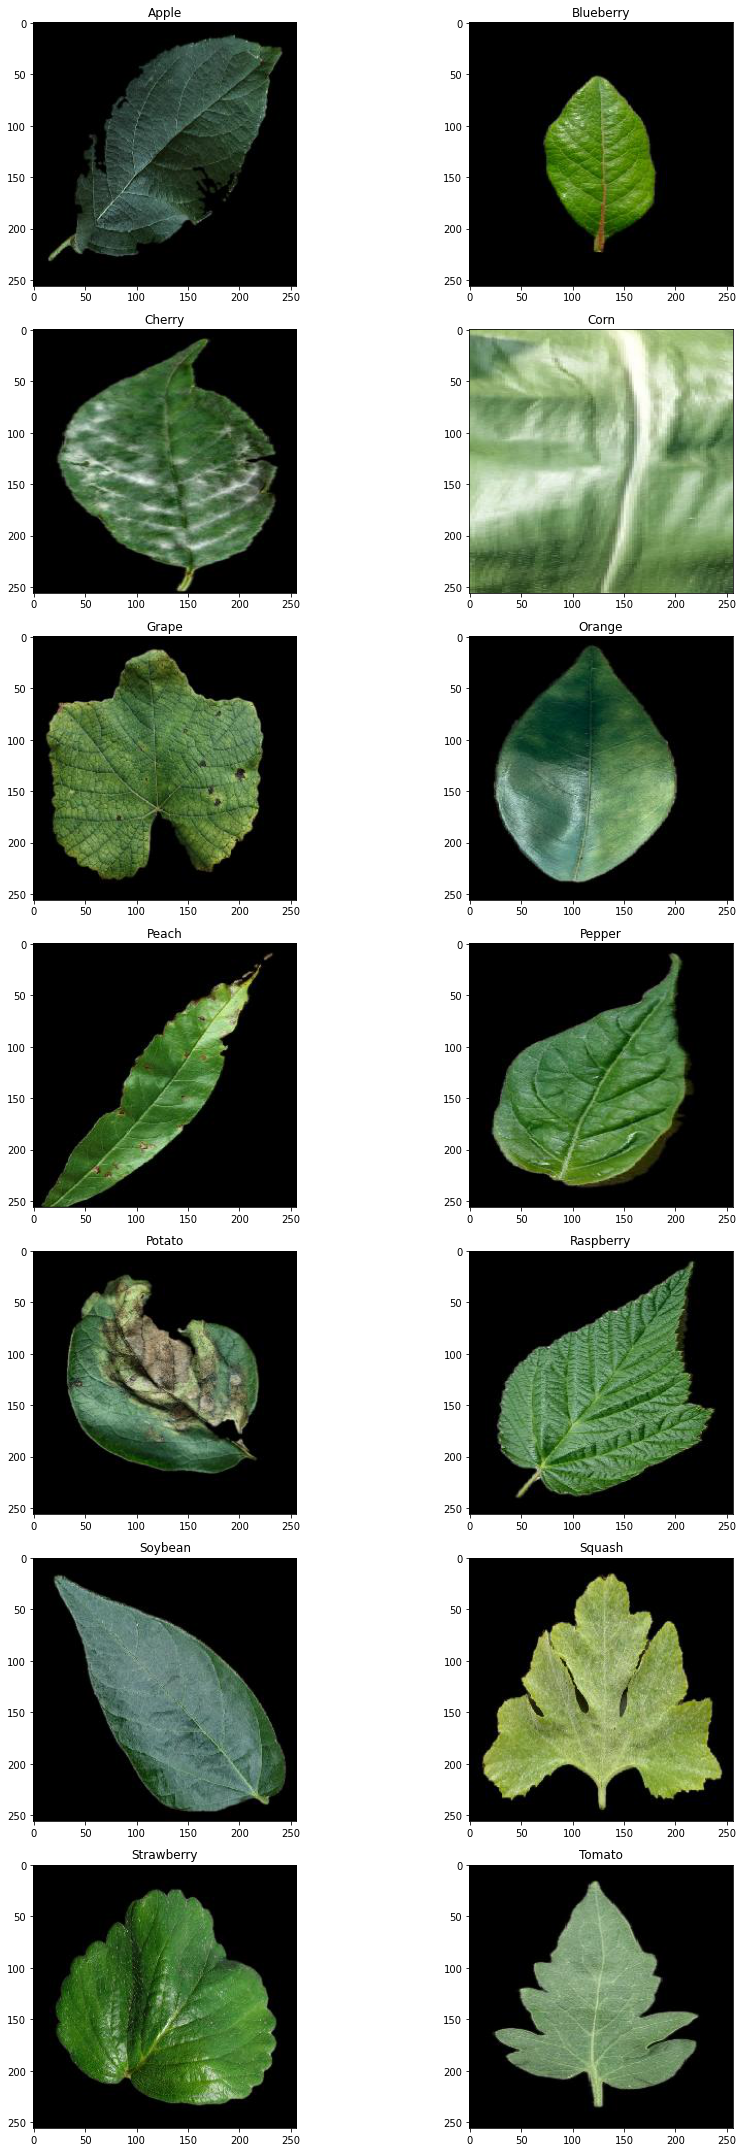

In [ ]:
# Plot example images from dataset
num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

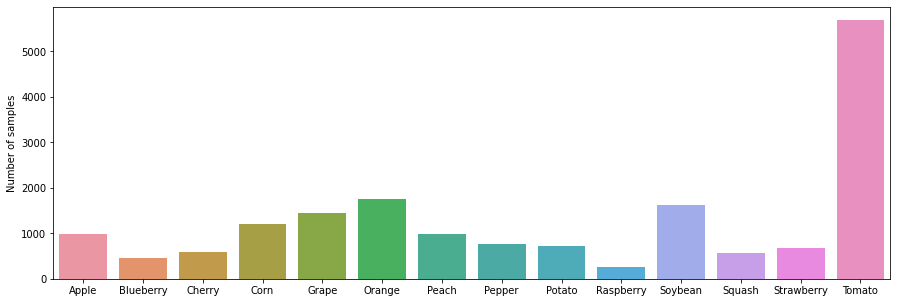

In [24]:
# Plot the dataset distribution
class_size = []
for label in labels:
  class_size.append(len([name for name in os.listdir('dataset/{}'.format(labels[label]))]))
plt.figure(figsize=(15,5))
plt.ylabel("Number of samples")
sns.barplot(y=class_size, x=list(labels.values()))
plt.show()

solutions for small dataset:
*   Data augmentation
*   Transfer learning


solutions for imbalanced classes:
*   Data augmentation
*   weighting the loss of each class inversely proportionally to its size
*   F1_score as main metric instead of accuracy/loss


# Data augmentation

In [7]:
batch_size = 64

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

training_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                      validation_split = 0.1, 
                                      rotation_range=360,
                                      shear_range = 10,
                                      zoom_range=[0.6,1.4],
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      brightness_range=[0.8,1.2],
                                      horizontal_flip=True,
                                      vertical_flip=True, 
                                      fill_mode="wrap")

In [28]:
train_gen = training_datagen.flow_from_directory(directory='dataset',
                                                 target_size=(256,256),
                                                 color_mode='rgb',
                                                 classes=None, # can be set to labels
                                                 class_mode='categorical',
                                                 batch_size = batch_size,
                                                 subset='training')
valid_gen = training_datagen.flow_from_directory(directory='dataset',
                                                target_size=(256,256),
                                                color_mode='rgb',
                                                classes=None, # can be set to labels
                                                class_mode='categorical',
                                                batch_size = batch_size,
                                                subset = 'validation')

Found 15963 images belonging to 14 classes.
Found 1765 images belonging to 14 classes.


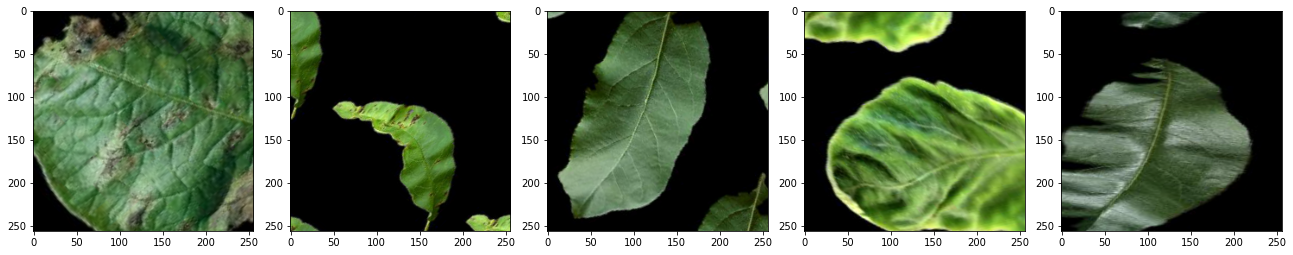

In [31]:
# Plot some augmented images (without VGG16 preprocessing)
num_row = 1
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(18*num_row,15*num_col))
for i in range(5):
    ax = axes[i]
    ax.imshow(train_gen[0][0][i]/255)
plt.tight_layout()
plt.show()

# Transfer learning

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

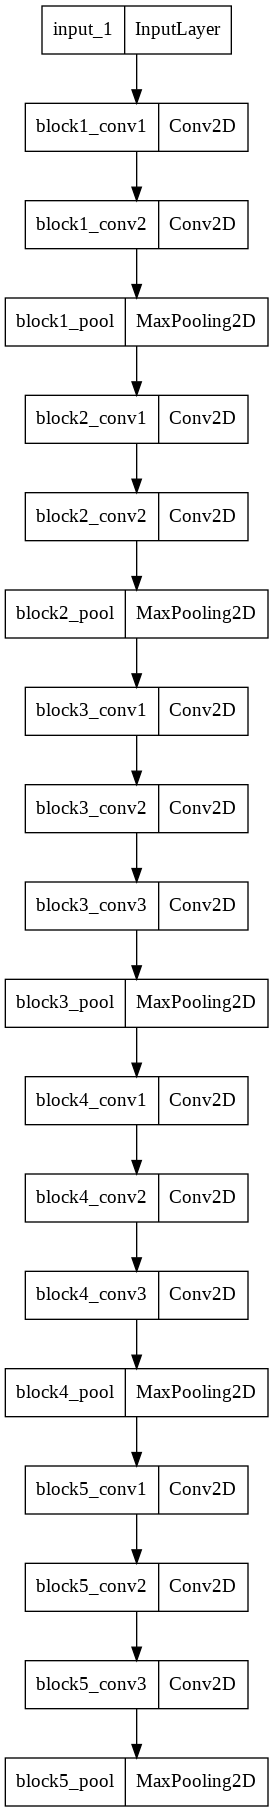

In [ ]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False, # remove classifier, take only feature-extraction part
    weights="imagenet", # use weights obtained in training imagenet
    input_shape=(256,256,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [ ]:
# Use the supernet as feature extractor
supernet.trainable = False 

def build_model():
  inputs = tfk.Input(shape=(256,256,3))               
  x = supernet(inputs)
  x = tfkl.Flatten(name='Flattening')(x)
  x = tfkl.BatchNormalization()(x)
  x = tfkl.Dropout(0.3, seed=seed)(x)
  x = tfkl.Dense(units=1024, kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
  x = tfkl.LeakyReLU(alpha=0.1)(x)
  x = tfkl.BatchNormalization()(x)
  x = tfkl.Dropout(0.3, seed=seed)(x)
  outputs = tfkl.Dense(units=14, activation= 'softmax', kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

  # Connect input and output through the Model class
  tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')


  from keras import backend as K

  # Recall and precision metrics are define to calculate the F1 score
  def recall_m(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      recall = true_positives / (possible_positives + K.epsilon())
      return recall

  def precision_m(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      return precision

  def f1_score(y_true, y_pred):
      precision = precision_m(y_true, y_pred)
      recall = recall_m(y_true, y_pred)
      return 2*((precision*recall)/(precision+recall+K.epsilon()))

  metrics = [
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
        f1_score
  ]

  # Compile the model
  tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=metrics)
  return tl_model

In [ ]:
# Class weights are used to reduce the effect of a highly imbalanced dataset
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
           'balanced',
            classes = np.unique(train_gen.classes), 
            y = train_gen.classes)

class_weights_dict = {}
for index, elem in enumerate(class_weights):
  class_weights_dict[index] = elem
print(class_weights_dict)

{0: 1.281139646869984, 1: 2.7083474720054292, 2: 2.1718367346938776, 3: 1.0499210734017363, 4: 0.8684038733543684, 5: 0.7244055182428752, 6: 1.2956980519480519, 7: 1.6548828529960606, 8: 1.7677740863787375, 9: 4.790816326530612, 10: 0.7836524300441826, 11: 2.205443492677535, 12: 1.8815417256011315, 13: 0.2225242556038809}


In [ ]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 32768)             0         
                                                                 
 batch_normalization_2 (Batc  (None, 32768)            131072    
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              33555456  
                                                             

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('models')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir,'cp'),
                                                    save_weights_only=False,
                                                    save_best_only=False)
  callbacks.append(ckpt_callback)


  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
  
  # profile batch removes some profiling so we're speeding up the precos
  # histogram_freq saves the histograms of weights
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                               profile_batch=0,
                                               histogram_freq=1)
  callbacks.append(tb_callback)

  # Save the history
  history_callback=tf.keras.callbacks.CSVLogger(filename = os.path.join(ckpt_dir,'history.csv'), separator=",", append=True)
  callbacks.append(history_callback)


  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
# Train the model
history = model.fit(
    x = train_gen,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = create_folders_and_callbacks("vgg16_LeakyReLU_BNorm_shear_f1"),
    class_weight=class_weights_dict
).history

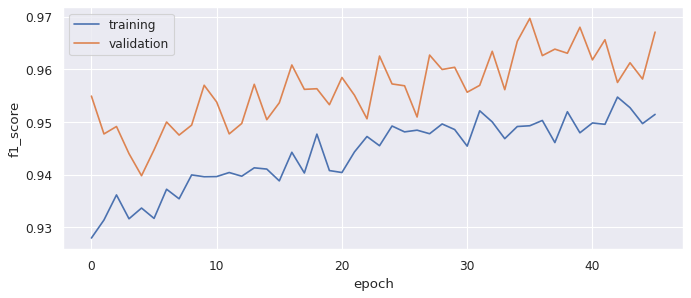

In [23]:
# Plot the F1 score for training and validation sets
csv = pd.read_csv(r'histories/history_pre_finetuning.csv')

from matplotlib.pyplot import figure
figure(figsize=(10, 4), dpi=80)
res = sns.lineplot(x="epoch", y="f1_score", data=csv, label='training')
res = sns.lineplot(x="epoch", y="val_f1_score", data=csv, label='validation')
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.show()

While interpreting the plot we tried to understand why the validation accuracy is greater than the training accuracy. A possible explanation is that when training, a percentage of the features are set to zero due to the Dropout layer. When testing on the validation set, all features are used. So the model at test time is more robust. Furthermore, the validation set is really small, so it is possible that its distribution does not represent the entire dataset.

In [10]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    

model = keras.models.load_model("models/vgg16_LeakyReLU_BNorm_shear_f1_Nov28_08-54-29/ckpts/cp", custom_objects={'f1_score':f1_score}, compile = True)

In [19]:
# Confusion Matrix and Classification Report
valid_gen.shuffle = False

Y_pred = model.predict(valid_gen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm2 = confusion_matrix(valid_gen.classes, y_pred)
print(cm2)
print('Classification Report')
print(classification_report(valid_gen.classes, y_pred, target_names=list(labels.values())))

Confusion Matrix
[[ 92   0   2   0   0   0   1   0   0   0   3   0   0   0]
 [  1  44   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  55   0   0   0   0   1   0   1   0   0   1   0]
 [  0   0   0 120   0   0   0   0   0   0   0   0   0   0]
 [  1   0   1   0 142   0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0 174   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  96   1   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0  73   0   0   2   0   0   0]
 [  0   0   1   0   0   0   0   1  61   0   7   0   0   1]
 [  0   0   0   0   0   0   0   0   0  26   0   0   0   0]
 [  1   0   2   0   1   0   0   0   0   0 157   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  57   0   0]
 [  0   1   0   0   0   0   0   0   1   4   0   0  61   0]
 [  4   3   8   0   2   0   1   4   8   0   9   0   1 529]]
Classification Report
              precision    recall  f1-score   support

       Apple       0.93      0.94      0.93        98
   Blueberry       0.92  

## Fine Tuning

In [ ]:
# Load the model and lower the learning rate
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model = keras.models.load_model("models/vgg16_LeakyReLU_BNorm_shear_f1_Nov28_08-54-29/ckpts/cp", custom_objects={'f1_score':f1_score}, compile = True)
from keras import backend as K
K.set_value(model.optimizer.lr, 1e-05)

In [ ]:
# Set all VGG layers to True
model.get_layer('vgg16').trainable = True # Now VGG (supernet) is trainable! 
for i, layer in enumerate(model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
# Freeze first 13 layers
for i, layer in enumerate(model.get_layer('vgg16').layers[:14]):
   layer.trainable = False

for i, layer in enumerate(model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
model.summary()

In [ ]:
# Train the model
history = model.fit(
    x = train_gen,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = create_folders_and_callbacks("vgg16_LeakyReLU_BNorm_shear_f1"),
    class_weight=class_weights_dict
).history

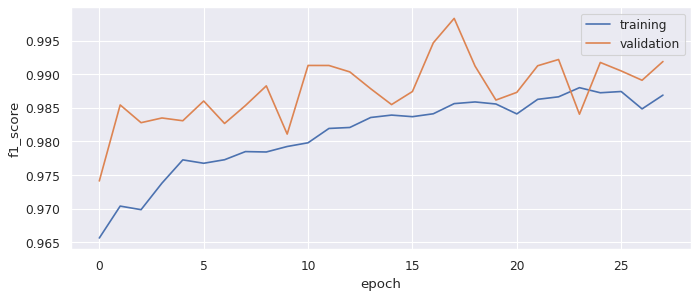

In [24]:
# Plot the F1 score for training and validation sets
csv = pd.read_csv(r'histories/history_post_finetuning.csv')

from matplotlib.pyplot import figure

figure(figsize=(10, 4), dpi=80)

res = sns.lineplot(x="epoch", y="f1_score", data=csv, label='training')
res = sns.lineplot(x="epoch", y="val_f1_score", data=csv, label='validation')

plt.show()

In [20]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model = keras.models.load_model("models/vgg16_LeakyReLU_BNorm_shear_f1_FT_Nov28_13-57-23/ckpts/cp", custom_objects={'f1_score':f1_score}, compile = True)

In [23]:
# Confusion Matrix and Classification Report
valid_gen.shuffle = False

Y_pred = model.predict(valid_gen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm2 = confusion_matrix(valid_gen.classes, y_pred)
print(cm2)
print('Classification Report')
print(classification_report(valid_gen.classes, y_pred, target_names=list(labels.values())))

Confusion Matrix
[[ 97   0   0   0   0   0   0   0   0   0   1   0   0   0]
 [  0  46   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  58   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 120   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 145   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0 173   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  97   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  76   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  68   0   2   0   1   0]
 [  0   0   1   0   0   0   0   0   0  25   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 161   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  57   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  67   0]
 [  2   0   5   0   0   0   1   1   2   0   3   1   0 554]]
Classification Report
              precision    recall  f1-score   support

       Apple       0.98      0.99      0.98        98
   Blueberry       0.98  